# Fire-Eye Deep Learning with CNNs

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow, suppresses logs

import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np


## Load and Inspect Data

In [ ]:
TF_FILES = '../data_collection/unfiltered_data/*tfrecord.gz'
FEATURES = ['fire_presence_mask', 'fire_presence_next_day_mask', 'uncertainty_mask', 'uncertainty_next_day_mask', 'elevation', 'wind_direction', 'wind_speed', 'energy_release_component', 'burn_index', 'precipitation', 'tempature_min', 'tempature_max', 'drought_index', 'vegetation', 'population_density']
KERNEL_SIZE = 64
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]



tfrecord_files = glob.glob(TF_FILES)

def parse_tfrecord(example_proto):
    feature_description = {
        'fire_mask': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'fire_mask_next_day': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'elevation': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'wind_direction': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'wind_speed': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'energy_release_component': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'burn_index': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'precipitation': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'tempature_min': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'tempature_max': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'drought_index': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'vegetation': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
        'population_density': tf.io.FixedLenFeature(shape=[64, 64], dtype=tf.float32),
    }
    return tf.io.parse_single_example(example_proto, feature_description)


# Some dataprocessing to split the fire mask and uncertainty masks.
def split_fire_mask(record):
    # Extract fire_mask as a Tensor (float32)
    fire_mask = record['fire_mask']  # Shape: [kernel, kernel]
    fire_mask_next_day = record['fire_mask_next_day']

    # Safely cast to uint8 for bitwise operations
    fire_mask_int = tf.cast(fire_mask, tf.uint8)
    fire_mask_next_day_int = tf.cast(fire_mask_next_day, tf.uint8)

    # Extract the uncertainty mask (bit 0)
    uncertainty_mask = tf.bitwise.bitwise_and(fire_mask_int, 1)
    uncertainty_next_mask = tf.bitwise.bitwise_and(fire_mask_next_day_int, 1)
    # Extract the fire presence mask (bit 1)
    fire_presence_mask = tf.bitwise.right_shift(fire_mask_int, 1)
    fire_next_presence_mask = tf.bitwise.right_shift(fire_mask_next_day_int, 1)
    # Add the new masks back into the record
    record['fire_presence_mask'] = tf.cast(fire_presence_mask, tf.float32)  # Convert back to float32
    record['uncertainty_mask'] = tf.cast(uncertainty_mask, tf.float32)      # Convert back to float32
    del record['fire_mask']

    record['fire_presence_next_day_mask'] = tf.cast(fire_next_presence_mask, tf.float32)  # Convert back to float32
    record['uncertainty_next_day_mask'] = tf.cast(uncertainty_next_mask, tf.float32)      # Convert back to float32
    del record['fire_mask_next_day']


    return record


def has_active_fire(record):
    # Check for active fire in fire_mask
    fire_mask = record['fire_presence_mask']  # Shape: [kernel, kernel]
    fire_mask_int = tf.cast(fire_mask, tf.uint8)
    # Identify fire classes (7, 8, or 9)
    active_fire = fire_mask_int == 1
    # Check if there is any active fire pixel
    return tf.reduce_any(active_fire)


raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")

parsed_dataset = raw_dataset.map(parse_tfrecord)
transformed_dataset = parsed_dataset.map(split_fire_mask)
filtered_dataset = transformed_dataset.filter(has_active_fire)

In [54]:
length = sum(1 for _ in filtered_dataset)
print(f"Dataset length: {length}")


Dataset length: 317


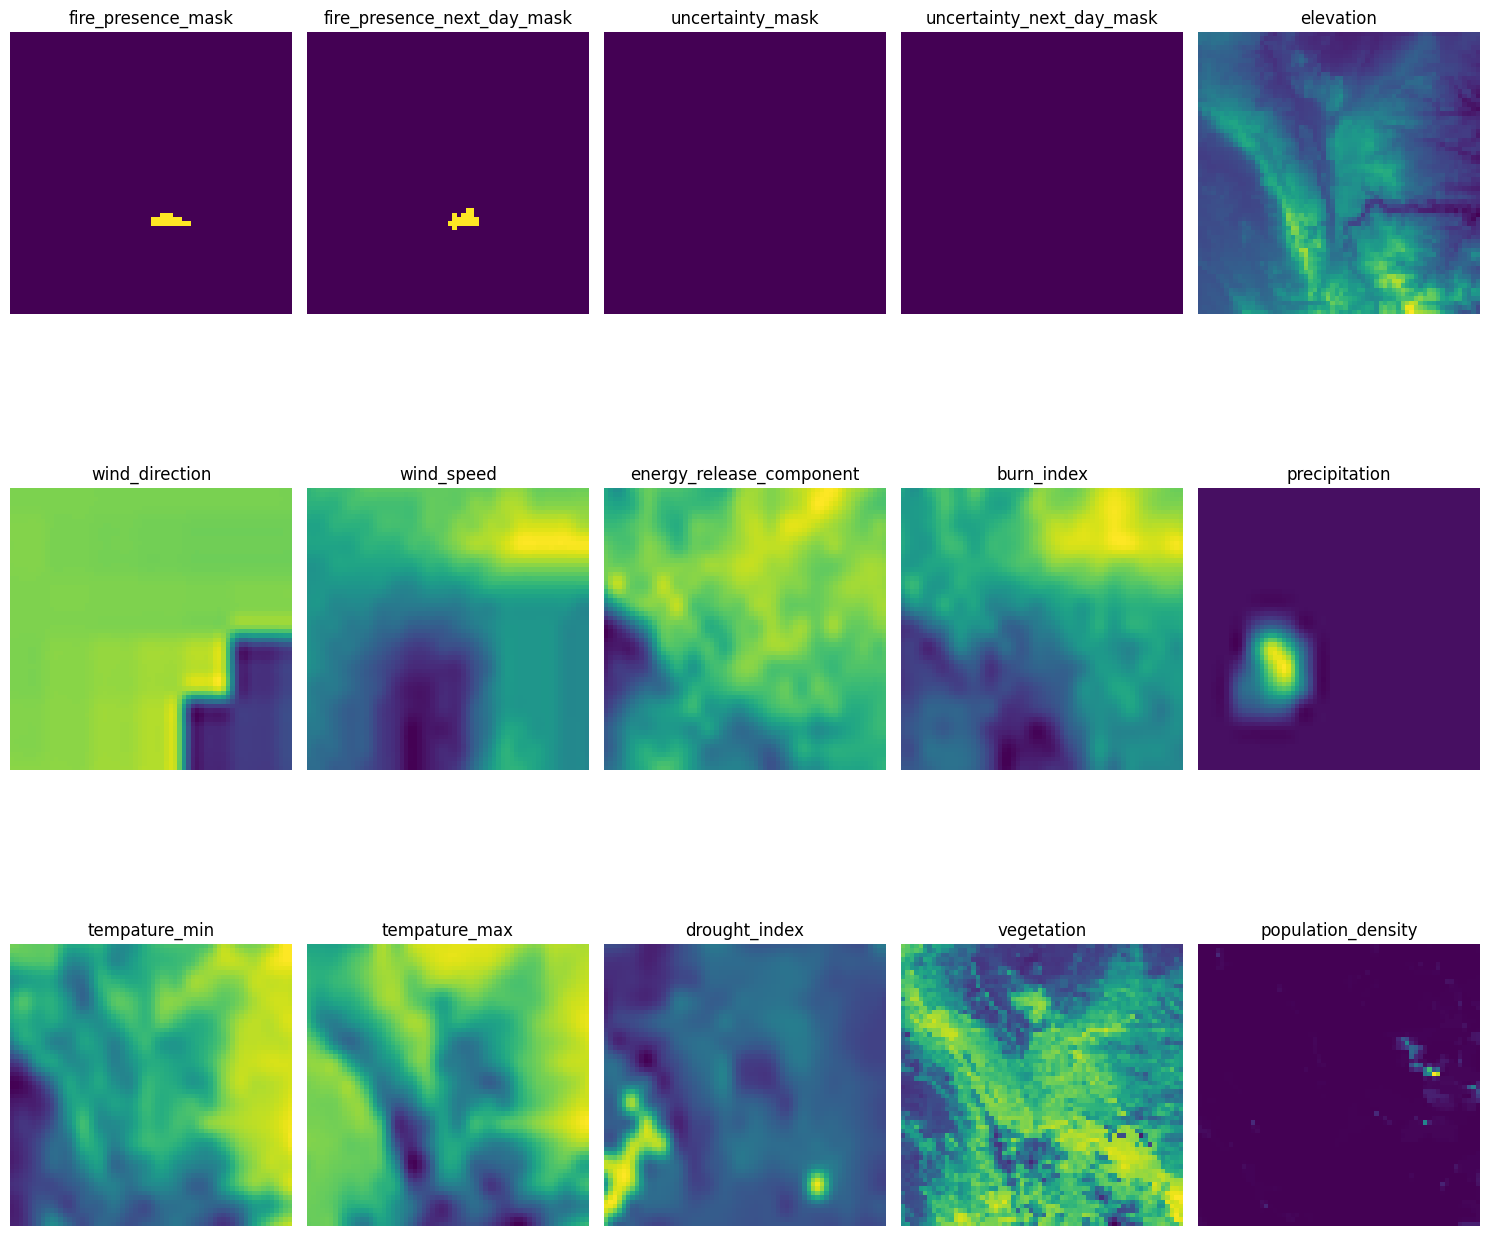

In [52]:
num_features = len(FEATURES)
cols = 5  # Number of columns for subplots
rows = (num_features + cols - 1) // cols  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

# Plot the features
for example in filtered_dataset.take(5):  # Assuming one example for all features
    for i, feature in enumerate(FEATURES):
        f_np = example[feature].numpy()
        im = axes[i].imshow(f_np, vmin=np.min(f_np), vmax=np.max(f_np), cmap='viridis')
        axes[i].set_title(feature)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


The problem with this dataset is that it's length is only 317 images. Because of limitations with the data export speed in google earth engine, I will just download the paper's dataset found [here](https://www.kaggle.com/datasets/fantineh/next-day-wildfire-spread/data). My plan of attack is to do my initial training on the provided dataset, and then finetune the model to match my data.

In [55]:
NEXT_DAY_FILES = "../data_collection/next_day_dataset/*.tfrecord"


next_day_tfrecord_files = glob.glob(NEXT_DAY_FILES)
next_day_dataset = tf.data.TFRecordDataset(next_day_tfrecord_files)

In [56]:
for i in next_day_dataset.take(1):
    print(i)

tf.Tensor(b'\n\xad\x82\r\n\x98\x80\x01\n\npopulation\x12\x88\x80\x01\x12\x84\x80\x01\n\x80\x80\x01\x90\x8f\x84@\xce\xa8\xa3?\x14\xd3\xf1?\x8e"x?%\xe0\xc2;\xb6B\xcd=\\k\xd8=\xaaD\xd6=\xb4a\x86@\x88\xb7\xab@\xc8x\x0cA\x0c\xaa\xbd@p\xa1\x80@\xbc\xa4\x8e@[x\xc9@\xf2\xe3\x88A\xd0\x8d\x97A\x18@\x94A\xf0G\tA<\xef\x19A\xb2\xae\x1fA*\xa8\x07A\xce\x05\x95@`\xbe(A0\x066A#\x03\xd9@\xf1X\xdc@\xea\xddMA\xd4\xa8\xb5A\x8c\xb1\xceA\xba\xcewB\xbc\x97\x10B\xb4\x0f\xb8A\xce\x14hA~*\x87AGb\x94BC\xf9\x19A\xa5\x88\xa3@j@\xa0@\xb2\x9b$@>\xb6\xd1@\xcey\x0eB.i3B\xb0\x1d_B\xfe\x94+BX\xc2rAK\xf5\xb1Adu\x8cA\xaa\x8b\xe8@\x1a\xb5\xdb@^\xde\x89A\xf0\xd8yA\xfb\x91xA\x176\xb1A$\xab\x07AS}\x17A\xb4\xdf|A\x1a\xd5\x85AA\xd8nA\x04t=A\x1e\x12%?\xd1\xa8NB\x06\x1bDB\xfe\xa3\xa9BY\xdc Ap\xdb\x8b@$af@\x81;q@\xd0\x148@\x00\x00\x00\x00\xd6\x7fQ<\xb8\r\'?\xd1S\xbb?\x86;8@\x84;8@\x86;8@\x84;8@\xc6\xed\x93A\x16\x18\xd3A\xf52\x8fA\xc0DdA\xf1\xef\xa4A{1\x8fA\xca\xb9\x83A\xc8\xb9\x83A"%\x88A\x02\xff\xecBVB\xc4A\xb6\x91hAr\xe3\xb8@\xac